**Лабораторна робота №1**

Виконала студентка групи КНСШ-12

Вільчинська Оксана-Олеся


**Завдання 1**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
import seaborn as sns
import numpy as np
#read in data using pandas
train_df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Deep Learning/Task 1/hourly_wages_data.csv")

#check data has been read in properly
train_df.head()


,wage_per_hour,union,education_yrs,experience_yrs,age,female,marr,south,manufacturing,construction
0,5.10,0,8,21,35,1,1,0,1,0
1,4.95,0,9,42,57,1,1,0,1,0
2,6.67,0,12,1,19,0,0,0,1,0
3,4.00,0,12,4,22,0,0,0,0,0
4,7.50,0,12,17,35,0,1,0,0,0


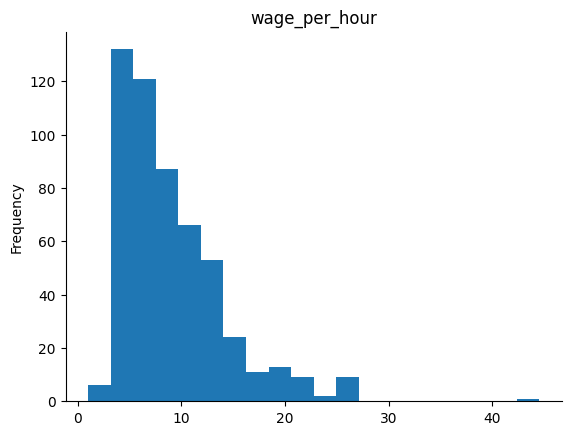

In [ ]:
# @title wage_per_hour

from matplotlib import pyplot as plt
train_df['wage_per_hour'].plot(kind='hist', bins=20, title='wage_per_hour')
plt.gca().spines[['top', 'right',]].set_visible(False)

# Підготовка даних:

In [ ]:
train_df.describe()

,wage_per_hour,union,education_yrs,experience_yrs,age,female,marr,south,manufacturing,construction
count,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000
mean,9.024064,0.179775,13.018727,17.822097,36.833333,0.458801,0.655431,0.292135,0.185393,0.044944
std,5.139097,0.384360,2.615373,12.379710,11.726573,0.498767,0.475673,0.455170,0.388981,0.207375
min,1.000000,0.000000,2.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.250000,0.000000,12.000000,8.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.780000,0.000000,12.000000,15.000000,35.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,11.250000,0.000000,15.000000,26.000000,44.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,44.500000,1.000000,18.000000,55.000000,64.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
train_df.agg(['min', 'max'])

,wage_per_hour,union,education_yrs,experience_yrs,age,female,marr,south,manufacturing,construction
min,1.0,0,2,0,18,0,0,0,0,0
max,44.5,1,18,55,64,1,1,1,1,1


# Оновлена модель

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

results = []
class HourlyWagesPredictionModel:
    def __init__(self, architecture=None, activation='relu', optimizer='adam', batch_size=64, epochs=10):
        self.architecture = architecture or [16, 32]
        self.activation = activation
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.epochs = epochs
        self.model = None

    def build_model(self, input_shape):
        model = Sequential()
        model.add(Input(shape=(input_shape,)))

        # Add hidden layers dynamically based on the architecture
        for layer_size in self.architecture:
            model.add(Dense(layer_size, activation=self.activation))

        # Output layer
        model.add(Dense(1))

        # Compile the model
        model.compile(optimizer=self.optimizer,
                      loss='mean_squared_error',
                      metrics=['mae'])

        self.model = model

    def plot_visualization(self, history):
        # Visualize the training and validation loss
        plt.plot(history.history['loss'], label='Training loss')
        plt.plot(history.history['val_loss'], label='Validation loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def train_model(self, train_X, train_Y):
        early_stopping_monitor = EarlyStopping(patience=4)

        history = self.model.fit(
            train_X, train_Y,
            validation_split=0.2,
            batch_size=self.batch_size,
            epochs=self.epochs,
            callbacks=[early_stopping_monitor]
        )

        return history

    def evaluate_model(self, X_test, Y_test):
        test_loss, base_mae = self.model.evaluate(X_test, Y_test)
        return test_loss, base_mae

    def save_results(self, history, test_loss, base_mae):
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        results.append([
            self.architecture, self.activation, self.batch_size,
            float(self.model.optimizer.learning_rate.numpy()), self.optimizer,
            self.epochs, train_loss, val_loss, test_loss
        ])
        return val_loss

    def run(self, train_X, train_Y, X_test, Y_test):
        input_shape = train_X.shape[1]
        self.build_model(input_shape)

        history = self.train_model(train_X, train_Y)
        self.plot_visualization(history)

        test_loss, base_mae = self.evaluate_model(X_test, Y_test)
        val_loss = self.save_results(history, test_loss, base_mae)

        print(f"Base model MAE: {base_mae}, validation loss: {test_loss}")
        return test_loss, val_loss, base_mae


#model_instance = DiabetesPredictionModel()
#base_model = model_instance.run(train_X, train_Y, X_test, Y_test)


# Нормалізація даних

In [ ]:
def normalization_data(preproces):
  for_normalization = ['wage_per_hour','education_yrs','experience_yrs', 'age']
  features0or1 = ['union','female','marr', 'south', 'manufacturing', 'construction']

  preproces.fit(train_df[for_normalization])
  features0or1_df = pd.DataFrame(train_df[features0or1])
  scaled_df = pd.DataFrame(preproces.transform(train_df[for_normalization]), columns=for_normalization)

  horizontal_concat = pd.concat([scaled_df,features0or1_df], axis=1)
  return horizontal_concat

In [ ]:
def split_data(data_X, data_Y):
  # Train/validation/test split(70% train, 20% validation, 10% test)
  return train_test_split(data_X, data_Y, test_size=0.1, random_state=52)

## Без скейлінгу

In [ ]:
# create a dataframe with all training data except the target column
data_X = train_df.drop(columns=['wage_per_hour'])
data_Y = train_df['wage_per_hour']
data_X.head()

,union,education_yrs,experience_yrs,age,female,marr,south,manufacturing,construction
0,0,8,21,35,1,1,0,1,0
1,0,9,42,57,1,1,0,1,0
2,0,12,1,19,0,0,0,1,0
3,0,12,4,22,0,0,0,0,0
4,0,12,17,35,0,1,0,0,0


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 261.6165 - mae: 14.9789 - val_loss: 191.7171 - val_mae: 12.4927
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 184.2404 - mae: 12.2350 - val_loss: 134.2019 - val_mae: 10.0382
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 118.8791 - mae: 9.5640 - val_loss: 89.2525 - val_mae: 7.5704
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 76.6053 - mae: 7.1504 - val_loss: 55.9476 - val_mae: 5.1217
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 45.8646 - mae: 4.9319 - val_loss: 36.7274 - val_mae: 3.4899
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 22.2167 - mae: 3.4189 - val_loss: 31.0816 - val_mae: 3.2789
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 20.1949 - mae: 3.4799 - val_loss: 33.1170 - val_mae: 3.7467
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 22.8466 - mae: 3.9273 - val_loss: 34.6837 - val_mae: 3.9945
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 22.0

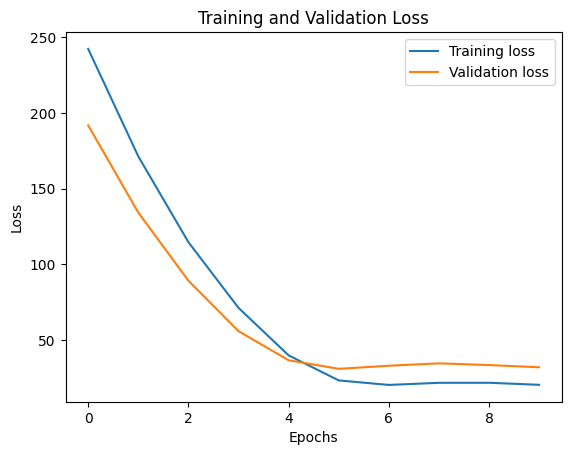

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 29.9562 - mae: 4.2383 
Base model MAE: 4.118624210357666, validation loss: 28.256223678588867


In [ ]:
train_X, X_test, train_Y, Y_test = split_data(data_X, data_Y)
model_instance = HourlyWagesPredictionModel()
base_model = model_instance.run(train_X, train_Y, X_test, Y_test)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
minmax = MinMaxScaler()
scaler_df = normalization_data(scaler)
minmax_df = normalization_data(minmax)

## StandardScaler

In [ ]:
# create a dataframe with all training data except the target column
data_X = scaler_df.drop(columns=['wage_per_hour'])
data_Y = scaler_df['wage_per_hour']
data_X.head()

,education_yrs,experience_yrs,age,union,female,marr,south,manufacturing,construction
0,-1.920733,0.256943,-0.156487,0,1,1,0,1,0
1,-1.538020,1.954858,1.721353,0,1,1,0,1,0
2,-0.389880,-1.360118,-1.522189,0,0,0,0,1,0
3,-0.389880,-1.117559,-1.266119,0,0,0,0,0,0
4,-0.389880,-0.066469,-0.156487,0,0,1,0,0,0


In [ ]:
# Train/validation/test split(70% train, 20% validation, 10% test)
train_X, X_test, train_Y, Y_test = train_test_split(train_X, train_Y, test_size=0.1, random_state=52)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.9491 - mae: 0.7344 - val_loss: 1.1400 - val_mae: 0.6508
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9018 - mae: 0.7082 - val_loss: 1.1217 - val_mae: 0.6467
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8717 - mae: 0.6986 - val_loss: 1.1113 - val_mae: 0.6390
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8220 - mae: 0.6943 - val_loss: 1.1053 - val_mae: 0.6285
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7960 - mae: 0.6787 - val_loss: 1.1022 - val_mae: 0.6162
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8222 - mae: 0.6818 - val_loss: 1.0998 - val_mae: 0.6076
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7536 - mae: 0.6488 - val_loss: 1.0974 - val_mae: 0.5986
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7859 - mae: 0.6551 - val_loss: 1.0950 - val_mae: 0.5912
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6568 - mae: 0.6184 - val_los

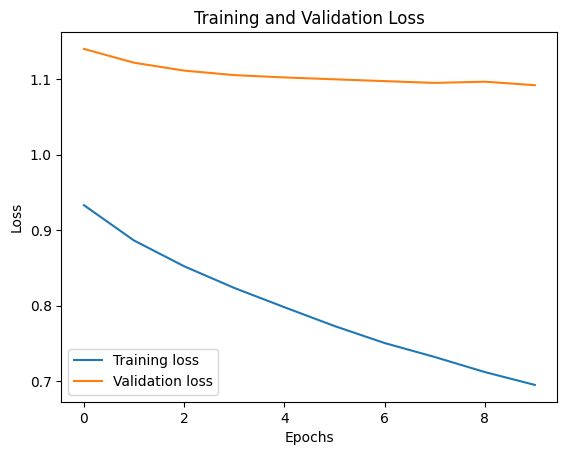

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1878 - mae: 0.8033 
Base model MAE: 0.7800655364990234, validation loss: 1.124074101448059


In [ ]:
train_X, X_test, train_Y, Y_test = split_data(data_X, data_Y)
model_instance = HourlyWagesPredictionModel()
base_model = model_instance.run(train_X, train_Y, X_test, Y_test)

## Minmax

In [ ]:
# create a dataframe with all training data except the target column
data_X = minmax_df.drop(columns=['wage_per_hour'])
data_Y = minmax_df['wage_per_hour']
data_X.head()

,education_yrs,experience_yrs,age,union,female,marr,south,manufacturing,construction
0,0.3750,0.381818,0.369565,0,1,1,0,1,0
1,0.4375,0.763636,0.847826,0,1,1,0,1,0
2,0.6250,0.018182,0.021739,0,0,0,0,1,0
3,0.6250,0.072727,0.086957,0,0,0,0,0,0
4,0.6250,0.309091,0.369565,0,0,1,0,0,0


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0365 - mae: 0.1492 - val_loss: 0.0309 - val_mae: 0.1222
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0219 - mae: 0.1177 - val_loss: 0.0302 - val_mae: 0.1294
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0215 - mae: 0.1182 - val_loss: 0.0251 - val_mae: 0.1107
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0157 - mae: 0.0962 - val_loss: 0.0220 - val_mae: 0.0900
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0140 - mae: 0.0891 - val_loss: 0.0211 - val_mae: 0.0844
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0137 - mae: 0.0867 - val_loss: 0.0200 - val_mae: 0.0826
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0115 - mae: 0.0805 - val_loss: 0.0196 - val_mae: 0.0835
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0119 - mae: 0.0829 - val_loss: 0.0191 - val_mae: 0.0825
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0115 - mae: 0.0801 - val_los

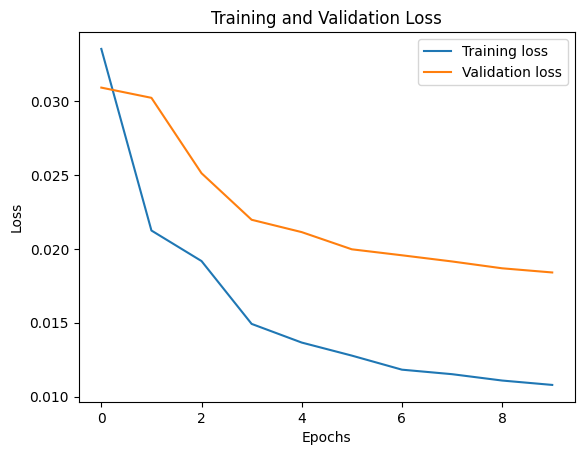

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0159 - mae: 0.0986 
Base model MAE: 0.09807568043470383, validation loss: 0.015575927682220936


In [ ]:
train_X, X_test, train_Y, Y_test = split_data(data_X, data_Y)
model_instance = HourlyWagesPredictionModel()
base_model = model_instance.run(train_X, train_Y, X_test, Y_test)

# plot_results

In [ ]:
def plot_results(results: dict, columns: str):
  df = pd.DataFrame(results).T.reset_index().rename(columns={'index':  columns})
  df_melted = df.melt(id_vars=[columns],
  value_vars=['loss','val_loss'],
  var_name='Metric', value_name='Value')
  plt.figure(figsize=(14, 7))
  sns.barplot(x=columns, y='Value', hue='Metric', data=df_melted)
  plt.title('Comparison of Loss and Validation Loss')
  plt.ylabel('Value')
  plt.xlabel(columns)
  plt.legend(title='Metric')
  df_melted = df.melt(id_vars=[columns], value_vars=['mae'],
  var_name='Metric', value_name='Value')
  plt.figure(figsize=(14, 7))
  sns.barplot(x=columns, y='Value', hue='Metric', data=df_melted)
  plt.title('Comparison of MAE')
  plt.ylabel('Value')
  plt.xlabel(columns)
  plt.legend(title='Metric')
  plt.show()

In [ ]:
def summarize_results(results):
    print(tabulate(
        results,
        headers=['architecture', 'activation', 'batch_size', 'lr',
                  'optimizer', 'epochs', 'train_loss', 'val_loss', 'test_loss'],
        tablefmt="grid",
        showindex="always"
    ))

# Порівняння оптимізаторів

------------------------------------------------------------
Training with activation function: SGD
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0758 - mae: 0.2332 - val_loss: 0.0627 - val_mae: 0.1951
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0476 - mae: 0.1802 - val_loss: 0.0481 - val_mae: 0.1638
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0378 - mae: 0.1603 - val_loss: 0.0399 - val_mae: 0.1447
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0320 - mae: 0.1451 - val_loss: 0.0350 - val_mae: 0.1324
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0295 - mae: 0.1404 - val_loss: 0.0321 - val_mae: 0.1237
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0268 - mae: 0.1334 - val_loss: 0.0302 - val_mae: 0.1175
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0250 - mae: 0.1272 - val_loss: 0.0290 - val_mae: 0.1131
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0244 - mae: 0.1266 - val_loss: 0.0280 

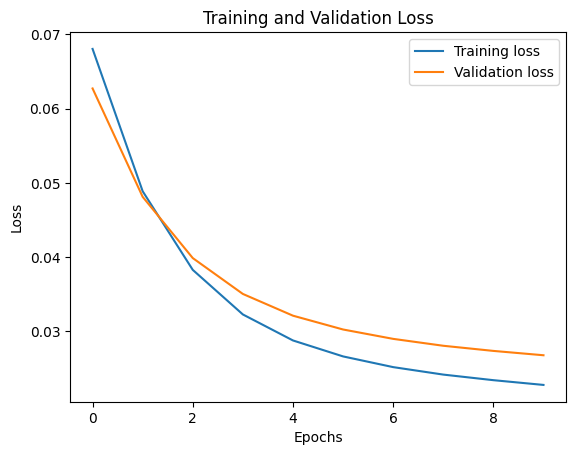

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0300 - mae: 0.1417 
Base model MAE: 0.13621863722801208, validation loss: 0.02992957830429077
SGD oprimizer MAE: 0.13621863722801208, loss: 0.02992957830429077
------------------------------------------------------------
Training with activation function: RMSprop
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0905 - mae: 0.2523 - val_loss: 0.0342 - val_mae: 0.1295
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0268 - mae: 0.1221 - val_loss: 0.0218 - val_mae: 0.0923
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0187 - mae: 0.1045 - val_loss: 0.0201 - val_mae: 0.0895
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0167 - mae: 0.0984 - val_loss: 0.0197 - val_mae: 0.0893
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0133 - mae: 0.0879 - val_loss: 0.0196 - val_mae: 0.0909
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0139 - mae: 0.0889 - val_loss: 0.0192 - val_mae: 0.0883
Epoc

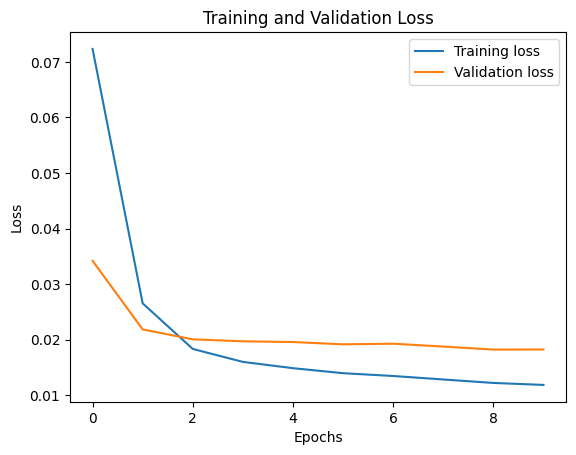

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0206 - mae: 0.1061 
Base model MAE: 0.10371305048465729, validation loss: 0.01927822083234787
RMSprop oprimizer MAE: 0.10371305048465729, loss: 0.01927822083234787
------------------------------------------------------------
Training with activation function: Adam
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0972 - mae: 0.2649 - val_loss: 0.0622 - val_mae: 0.1875
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0506 - mae: 0.1729 - val_loss: 0.0398 - val_mae: 0.1418
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0352 - mae: 0.1431 - val_loss: 0.0308 - val_mae: 0.1314
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0254 - mae: 0.1247 - val_loss: 0.0280 - val_mae: 0.1293
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0243 - mae: 0.1265 - val_loss: 0.0263 - val_mae: 0.1248
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0216 - mae: 0.1186 - val_loss: 0.0242 - val_mae: 0.1167
E

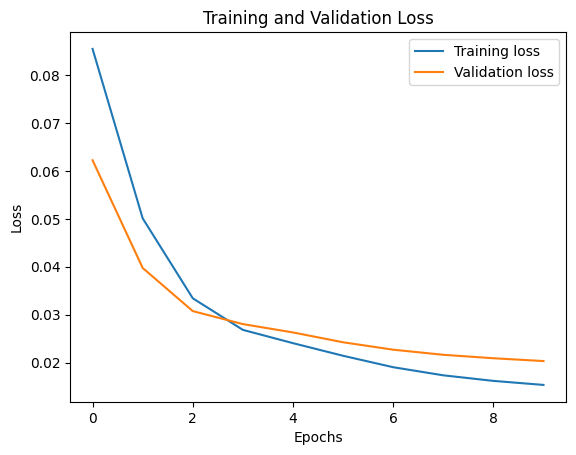

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0266 - mae: 0.1252 
Base model MAE: 0.11958238482475281, validation loss: 0.02467813901603222
Adam oprimizer MAE: 0.11958238482475281, loss: 0.02467813901603222
------------------------------------------------------------
Training with activation function: Adadelta
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1076 - mae: 0.2640 - val_loss: 0.1245 - val_mae: 0.2912
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1056 - mae: 0.2661 - val_loss: 0.1244 - val_mae: 0.2910
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1079 - mae: 0.2608 - val_loss: 0.1242 - val_mae: 0.2908
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1079 - mae: 0.2677 - val_loss: 0.1241 - val_mae: 0.2907
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1080 - mae: 0.2672 - val_loss: 0.1240 - val_mae: 0.2905
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1172 - mae: 0.2769 - val_loss: 0.1238 - val_mae: 0.2903

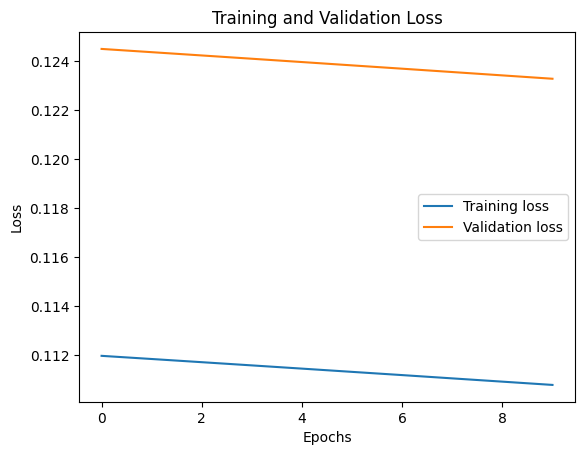

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0897 - mae: 0.2388 
Base model MAE: 0.24362774193286896, validation loss: 0.09239788353443146
Adadelta oprimizer MAE: 0.24362774193286896, loss: 0.09239788353443146
------------------------------------------------------------
Training with activation function: Adagrad
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0216 - mae: 0.1222 - val_loss: 0.0238 - val_mae: 0.1249
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0201 - mae: 0.1157 - val_loss: 0.0225 - val_mae: 0.1195
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0189 - mae: 0.1135 - val_loss: 0.0214 - val_mae: 0.1149
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0172 - mae: 0.1058 - val_loss: 0.0206 - val_mae: 0.1114
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0165 - mae: 0.1030 - val_loss: 0.0199 - val_mae: 0.1087
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0157 - mae: 0.0991 - val_loss: 0.0193 - val_mae: 0.106

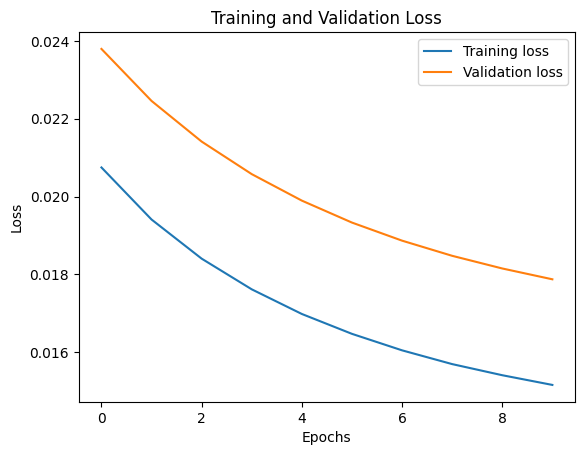

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0214 - mae: 0.1204 
Base model MAE: 0.11943020671606064, validation loss: 0.020830154418945312
Adagrad oprimizer MAE: 0.11943020671606064, loss: 0.020830154418945312
------------------------------------------------------------
Training with activation function: Adamax
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0675 - mae: 0.2165 - val_loss: 0.0417 - val_mae: 0.1492
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0318 - mae: 0.1434 - val_loss: 0.0260 - val_mae: 0.1083
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0206 - mae: 0.1134 - val_loss: 0.0219 - val_mae: 0.0990
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0193 - mae: 0.1071 - val_loss: 0.0209 - val_mae: 0.0967
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0184 - mae: 0.1037 - val_loss: 0.0202 - val_mae: 0.0942
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0167 - mae: 0.0999 - val_loss: 0.0195 - val_mae: 0

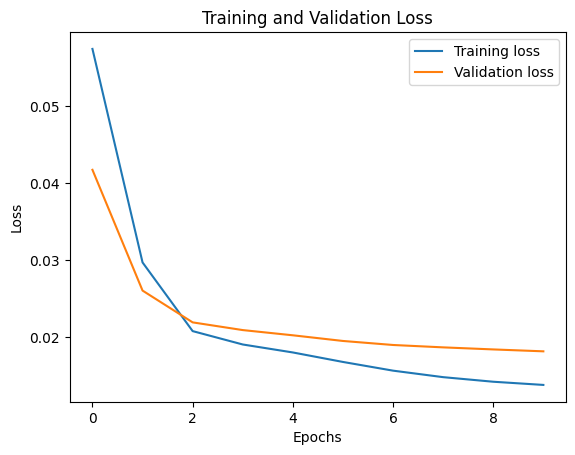

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0252 - mae: 0.1178 
Base model MAE: 0.11689978837966919, validation loss: 0.024240804836153984
Adamax oprimizer MAE: 0.11689978837966919, loss: 0.024240804836153984
------------------------------------------------------------
Training with activation function: Nadam
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.1184 - mae: 0.3153 - val_loss: 0.0827 - val_mae: 0.2506
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0745 - mae: 0.2398 - val_loss: 0.0532 - val_mae: 0.1863
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0473 - mae: 0.1832 - val_loss: 0.0348 - val_mae: 0.1379
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0288 - mae: 0.1353 - val_loss: 0.0260 - val_mae: 0.1070
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0196 - mae: 0.1067 - val_loss: 0.0231 - val_mae: 0.0929
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0182 - mae: 0.1003 - val_loss: 0.0221 - val_mae: 0.0892
E

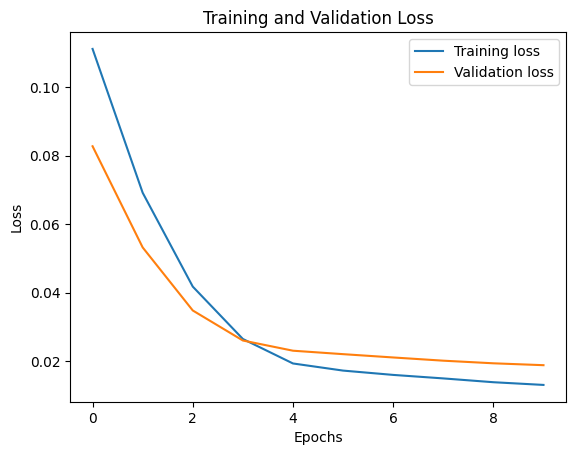

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0232 - mae: 0.1129 
Base model MAE: 0.1113150417804718, validation loss: 0.022339312359690666
Nadam oprimizer MAE: 0.1113150417804718, loss: 0.022339312359690666


In [ ]:
optimizers = ['SGD', 'RMSprop', 'Adam', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam']
histories = {}
optimizers_results = {}
for opt in optimizers:
  print("-" * 60)
  print(f"Training with activation function: {opt}")
  model_instance = HourlyWagesPredictionModel(optimizer=opt.lower())
  loss, val_loss, mae = model_instance.run(train_X, train_Y, X_test, Y_test)
  optimizers_results[opt] = {'loss': loss, 'mae': mae, 'val_loss': val_loss}
  print(f"{opt} oprimizer MAE: {mae}, loss: {loss}")

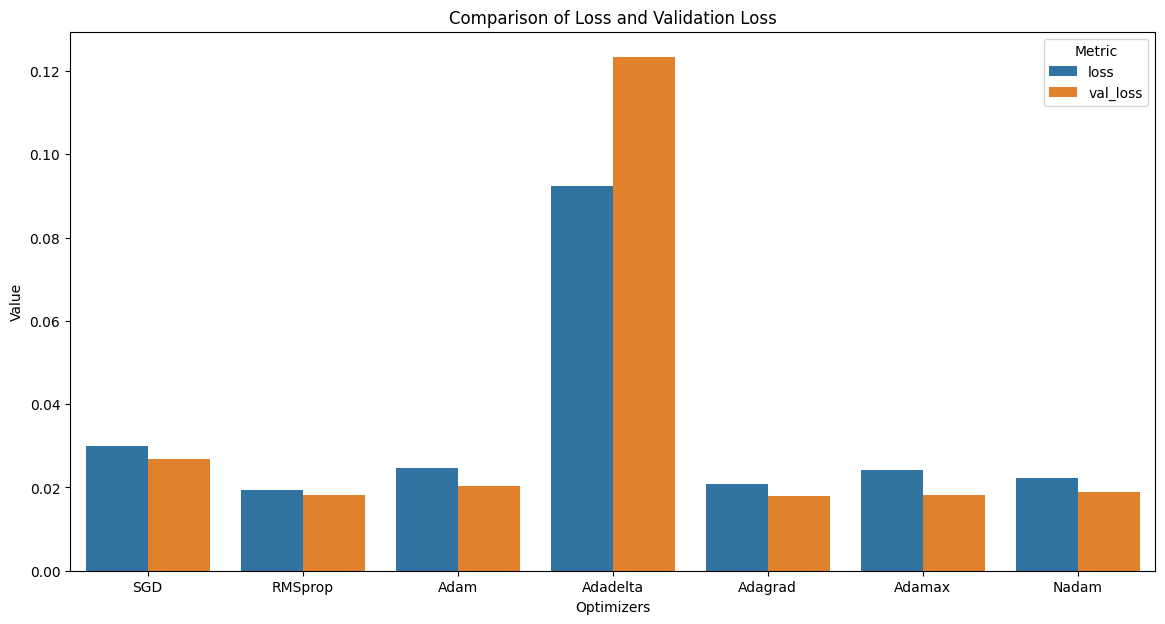

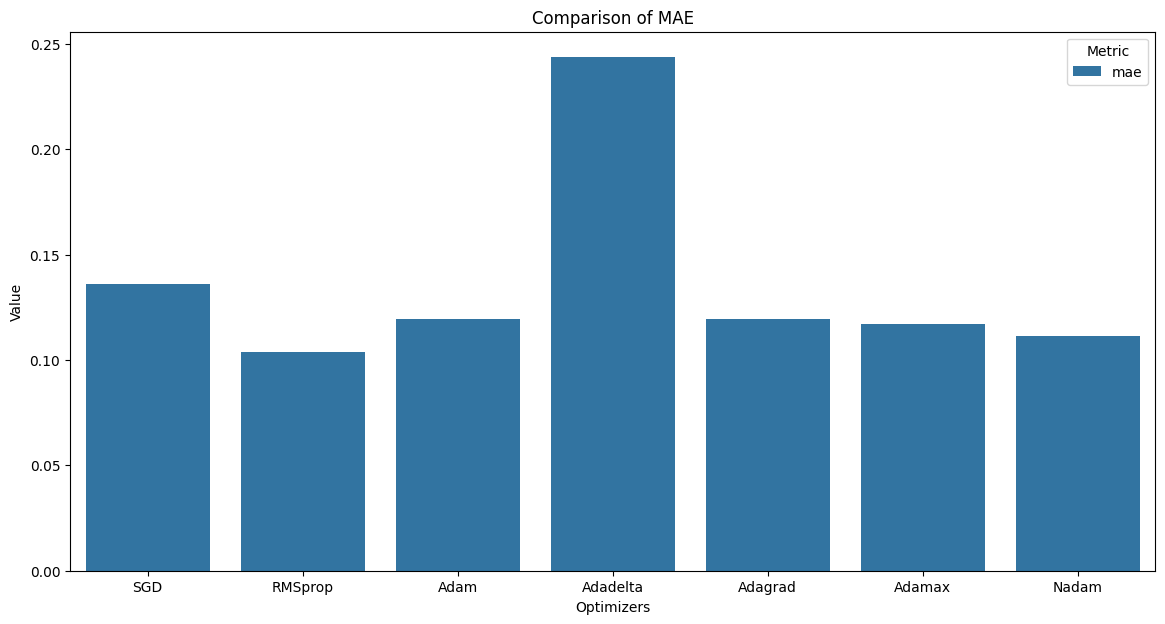

+----+----------------+--------------+--------------+-------+-------------+----------+--------------+------------+-------------+
|    | architecture   | activation   |   batch_size |    lr | optimizer   |   epochs |   train_loss |   val_loss |   test_loss |
+====+================+==============+==============+=======+=============+==========+==============+============+=============+
|  0 | [16, 32]       | relu         |           64 | 0.01  | sgd         |       10 |    0.022755  |  0.0267549 |   0.0299296 |
+----+----------------+--------------+--------------+-------+-------------+----------+--------------+------------+-------------+
|  1 | [16, 32]       | relu         |           64 | 0.001 | rmsprop     |       10 |    0.0118595 |  0.0182414 |   0.0192782 |
+----+----------------+--------------+--------------+-------+-------------+----------+--------------+------------+-------------+
|  2 | [16, 32]       | relu         |           64 | 0.001 | adam        |       10 |    0.01535

In [ ]:
plot_results(optimizers_results, "Optimizers")
summarize_results(results)

# Порівняння активаційних функцій

------------------------------------------------------------
Training with activation function: relu
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0220 - mae: 0.1110 - val_loss: 0.0209 - val_mae: 0.1014
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0139 - mae: 0.0899 - val_loss: 0.0215 - val_mae: 0.1047
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0135 - mae: 0.0921 - val_loss: 0.0198 - val_mae: 0.0959
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0124 - mae: 0.0859 - val_loss: 0.0181 - val_mae: 0.0844
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0114 - mae: 0.0783 - val_loss: 0.0176 - val_mae: 0.0797
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0114 - mae: 0.0785 - val_loss: 0.0173 - val_mae: 0.0779
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0097 - mae: 0.0727 - val_loss: 0.0173 - val_mae: 0.0778
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0106 - mae: 0.0770 - val_loss: 0.0173 - v

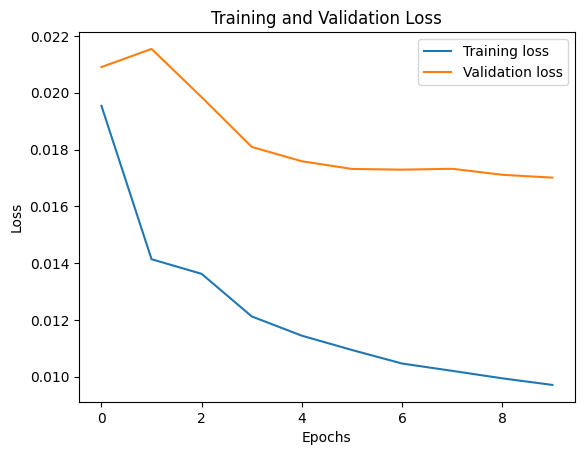

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0179 - mae: 0.0965 
Base model MAE: 0.09441566467285156, validation loss: 0.016913361847400665
relu activation MAE: 0.09441566467285156, loss: 0.016913361847400665
------------------------------------------------------------
Training with activation function: sigmoid
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.3775 - mae: 0.6035 - val_loss: 0.2086 - val_mae: 0.4472
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1623 - mae: 0.3862 - val_loss: 0.0736 - val_mae: 0.2586
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0511 - mae: 0.2058 - val_loss: 0.0217 - val_mae: 0.1165
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0143 - mae: 0.0994 - val_loss: 0.0179 - val_mae: 0.0724
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0152 - mae: 0.0884 - val_loss: 0.0244 - val_mae: 0.0961
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0206 - mae: 0.1049 - val_loss: 0.0237 - val_mae: 0.0

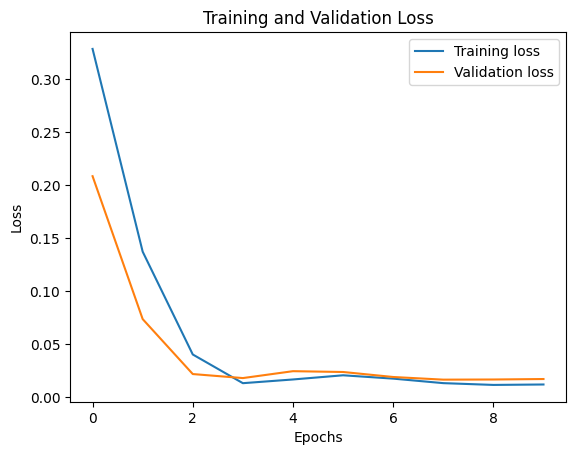

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0196 - mae: 0.1067 
Base model MAE: 0.10828777402639389, validation loss: 0.01949424482882023
sigmoid activation MAE: 0.10828777402639389, loss: 0.01949424482882023
------------------------------------------------------------
Training with activation function: tanh
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0685 - mae: 0.2123 - val_loss: 0.0480 - val_mae: 0.1657
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0436 - mae: 0.1693 - val_loss: 0.0384 - val_mae: 0.1419
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0295 - mae: 0.1365 - val_loss: 0.0328 - val_mae: 0.1252
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0227 - mae: 0.1171 - val_loss: 0.0285 - val_mae: 0.1142
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0194 - mae: 0.1085 - val_loss: 0.0247 - val_mae: 0.1024
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0158 - mae: 0.0973 - val_loss: 0.0210 - val_mae: 0.0906
Ep

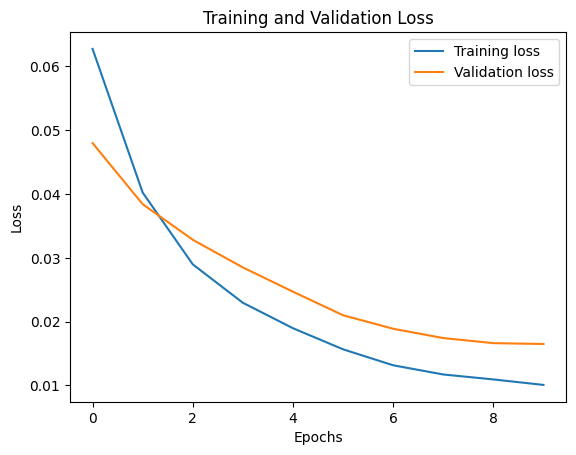

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0155 - mae: 0.0988 
Base model MAE: 0.09739464521408081, validation loss: 0.014926789328455925
tanh activation MAE: 0.09739464521408081, loss: 0.014926789328455925


In [ ]:
activations = ['relu', 'sigmoid', 'tanh']
histories = {}
activation_results = {}
for act in activations:
  print("-" * 60)
  print(f"Training with activation function: {act}")
  model_instance = HourlyWagesPredictionModel(activation=act)
  loss, val_loss, mae = model_instance.run(train_X, train_Y, X_test, Y_test)
  activation_results[act] = {'loss': loss, 'mae': mae, 'val_loss': val_loss}
  print(f"{act} activation MAE: {mae}, loss: {loss}")

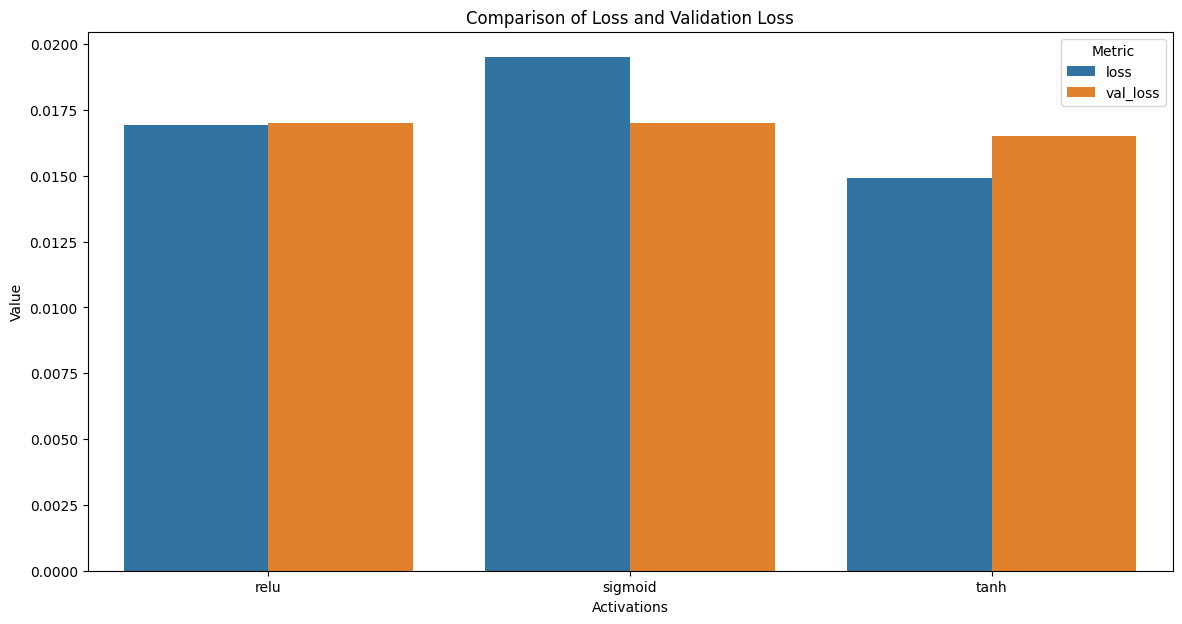

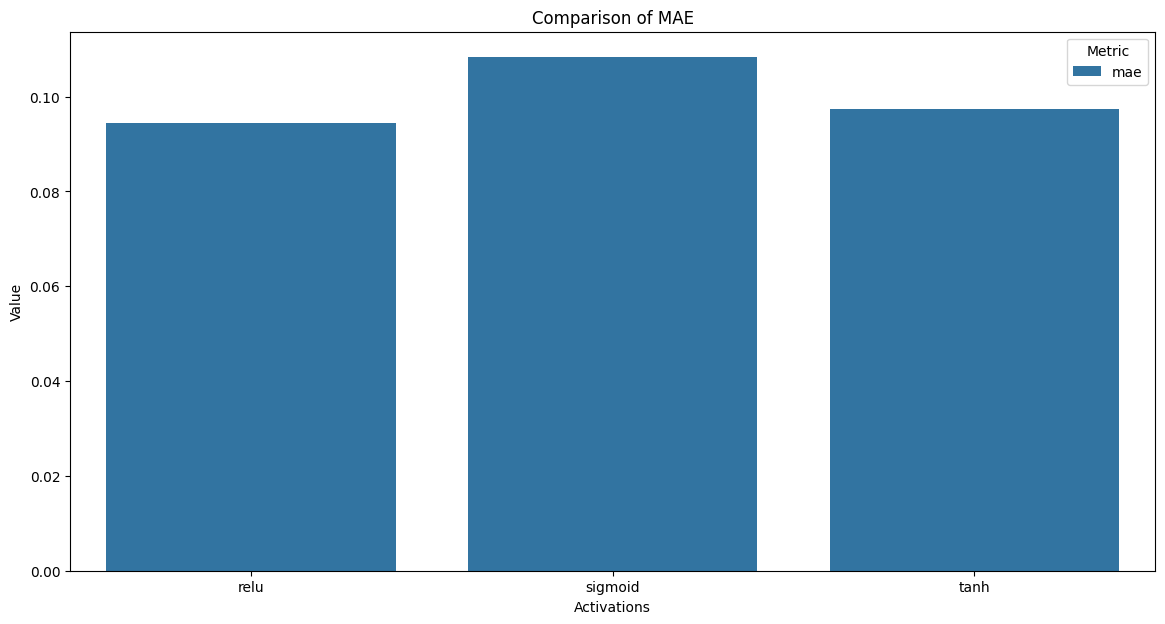

+----+----------------+--------------+--------------+-------+-------------+----------+--------------+------------+-------------+
|    | architecture   | activation   |   batch_size |    lr | optimizer   |   epochs |   train_loss |   val_loss |   test_loss |
+====+================+==============+==============+=======+=============+==========+==============+============+=============+
|  0 | [16, 32]       | relu         |           64 | 0.01  | sgd         |       10 |   0.022755   |  0.0267549 |   0.0299296 |
+----+----------------+--------------+--------------+-------+-------------+----------+--------------+------------+-------------+
|  1 | [16, 32]       | relu         |           64 | 0.001 | rmsprop     |       10 |   0.0118595  |  0.0182414 |   0.0192782 |
+----+----------------+--------------+--------------+-------+-------------+----------+--------------+------------+-------------+
|  2 | [16, 32]       | relu         |           64 | 0.001 | adam        |       10 |   0.01535 

In [ ]:
plot_results(activation_results, "Activations")
summarize_results(results)

# Стара версія моделі:

In [ ]:
results = []
def create_model(train_X, train_Y, X_test, Y_test, activation='relu', optimizer='adam', epochs=10, batch_size = 64, architecture = [16, 32]):
  model = Sequential()
  #get number of columns in training data
  n_cols = train_X.shape[1]
  model.add(Input(shape=(n_cols,)))
  #add model layers
  '''model.add(Dense(256, activation=activation))
  model.add(Dense(64, activation=activation))
  model.add(Dense(32, activation=activation))'''
  map(lambda i: model.add(Dense(i, activation=activation)), range(len(architecture)))
  model.add(Dense(1))

  model.compile(optimizer=optimizer,
                loss='mean_squared_error',
                metrics=['mae'])
  early_stopping_monitor = EarlyStopping(patience=4)

  h = model.fit(train_X, train_Y,
                validation_split=0.2, batch_size = batch_size,
                epochs=epochs,
                callbacks=[early_stopping_monitor])
  train_loss = h.history['loss'][-1]
  val_loss = h.history['val_loss'][-1]
  plot_visualization(h)
  test_loss, base_mae = model.evaluate(X_test, Y_test)
  print(f"Base model MAE: {base_mae}, validation loss: {test_loss}")
  results.append(
                  [ architecture, activation, batch_size, model.optimizer.learning_rate,
                  optimizer, epochs,
                   train_loss, val_loss, test_loss])
  return test_loss, val_loss, base_mae

base_model = create_model(train_X, train_Y, X_test, Y_test)

## Порівняння оптимізаторів

In [ ]:
optimizers = ['SGD', 'RMSprop', 'Adam', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam']
histories = {}
optimizers_results = {}
for opt in optimizers:
  print("-" * 60)
  print(f"Training with activation function: {opt}")
  loss, val_loss, mae = create_model(train_X, train_Y, X_test, Y_test, optimizer=opt.lower())
  optimizers_results[opt] = {'loss': loss, 'mae': mae, 'val_loss':
  val_loss}
  print(f"{opt} oprimizer MAE: {mae}, loss: {loss}")

## Порівняння активаційних функцій

In [ ]:
activations = ['relu', 'sigmoid', 'tanh']
histories = {}
activation_results = {}
for act in activations:
  print("-" * 60)
  print(f"Training with activation function: {act}")
  loss, val_loss, mae = create_model(train_X, train_Y, X_test, Y_test, activation=act)
  activation_results[act] = {'loss': loss, 'mae': mae, 'val_loss':
  val_loss}
  print(f"{act} activation MAE: {mae}, loss: {loss}")

In [ ]:
plot_results(activation_results, "Activations")

In [ ]:
print(tabulate(
    results,
    headers=['architecture', 'activation', 'batch_size', 'lr',
             'optim', 'epoch', 'train_loss', 'val_loss', 'test_loss'],
    tablefmt="grid",
    showindex="always"
    )
)